In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
import json
import decimal
import boto3
from boto3.dynamodb.conditions import Key, Attr

In [26]:
dynamodb = boto3.resource('dynamodb')
post_table = dynamodb.Table('posts')
comment_table = dynamodb.Table('comments')

In [27]:
# Helper class to convert a DynamoDB item to JSON.
class DecimalEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, decimal.Decimal):
            if o % 1 > 0:
                return float(o)
            else:
                return int(o)
        return super(DecimalEncoder, self).default(o)



posts = []
    
response = comment_table.scan(
    
    )

for i in response['Items']:
    posts.append(json.loads(json.dumps(i, cls=DecimalEncoder)))

while 'LastEvaluatedKey' in response:
    response = comment_table.scan(
        ExclusiveStartKey=response['LastEvaluatedKey']
        )

    for i in response['Items']:
        posts.append(json.loads(json.dumps(i, cls=DecimalEncoder)))

In [28]:
df = pd.DataFrame(posts)
df.head()

,comment_id,post_user,subreddit,post_date,score,votes_up,awards,comment_parent,comment_depth,votes_down,post_id,gilded,body
0,t1_f507ph6,t2_4ofie5cy,AmItheAsshole,1571952022,0,0,[],t3_dmcw3y,0,0,t3_dmcw3y,0,NTA - That's pure comedy right there.
1,t1_f43sa8o,t2_4uzl8ko,tifu,1571373440,1,1,[],t3_dj95o8,0,0,t3_dj95o8,0,It’s cause it makes you looks Muslim bro
2,t1_f4aiyb5,t2_3sqf72hz,AmItheAsshole,1571524755,-6,-6,[],t1_f49rjr5,6,0,t3_djvsug,0,"Fair question, but no. If OP has spent time wi..."
3,t1_evptaf7,t2_8z660,ProRevenge,1564708653,3,3,[],t1_evppdql,4,0,t3_ckpob7,0,Maybe Russia.
4,t1_f4i41t7,t2_15zkq6,tifu,1571628631,1,1,[],t3_dkm5gj,0,0,t3_dkm5gj,0,Well you're acting like the ball is in his cou...


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535223 entries, 0 to 535222
Data columns (total 13 columns):
comment_id        535223 non-null object
post_user         535223 non-null object
subreddit         535223 non-null object
post_date         535223 non-null int64
score             535223 non-null int64
votes_up          535223 non-null int64
awards            535223 non-null object
comment_parent    535223 non-null object
comment_depth     535223 non-null int64
votes_down        535223 non-null int64
post_id           535223 non-null object
gilded            535223 non-null int64
body              535223 non-null object
dtypes: int64(6), object(7)
memory usage: 53.1+ MB


In [30]:
df.post_date = pd.to_datetime(df.post_date,unit='s')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535223 entries, 0 to 535222
Data columns (total 13 columns):
comment_id        535223 non-null object
post_user         535223 non-null object
subreddit         535223 non-null object
post_date         535223 non-null datetime64[ns]
score             535223 non-null int64
votes_up          535223 non-null int64
awards            535223 non-null object
comment_parent    535223 non-null object
comment_depth     535223 non-null int64
votes_down        535223 non-null int64
post_id           535223 non-null object
gilded            535223 non-null int64
body              535223 non-null object
dtypes: datetime64[ns](1), int64(5), object(7)
memory usage: 53.1+ MB


In [32]:
df.gilded.value_counts()

0     534885
1        296
2         25
3          6
4          5
5          3
9          2
17         1
Name: gilded, dtype: int64

This is just bad.  I am so in the minority that I do not know if I will find anything. I have a feeling this is in part due to my scraper and not giving posts enough time to gain things.  I am going to have to modify my scraper to only grab posts that are over 24 hours old and see if this helps.  Not sure it will but worth trying.

In [34]:
df.subreddit.value_counts()

AmItheAsshole    227762
ProRevenge       114873
tifu             113127
pettyrevenge      42802
confession        36659
Name: subreddit, dtype: int64

In [35]:
df['is_gilded'] = df.gilded > 0

In [40]:
print('Percent Gilded: {}'.format((df.is_gilded.sum() / df.shape[0])*100))

Percent Gilded: 0.06315124723713293


This is way to imbalanced for me to think I will get a working model.  I think this should be a little higher. not much but a little.

In [37]:
df.pivot_table(index='is_gilded', columns='subreddit',aggfunc='count')['body']

subreddit,AmItheAsshole,ProRevenge,confession,pettyrevenge,tifu
is_gilded,,,,,
False,227662,114795,36644,42774,113010
True,100,78,15,28,117


In [38]:
import pickle 

In [39]:
df.to_pickle('data/comments.pkl')

Lets look at the Score as this may be better

Text(0.5, 1.0, 'Vote Score Hist')

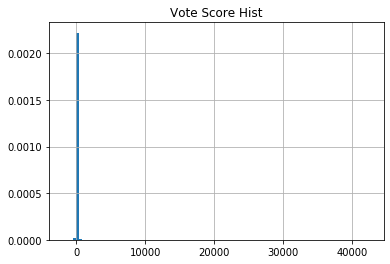

In [86]:
df.score.hist(bins=100, density=True)
plt.title('Vote Score Hist')

Well that is useless.  What does it look like if I get rid of the first ones that are washing out everything.

Text(0.5, 1.0, 'Vote Score > 1000 Hist')

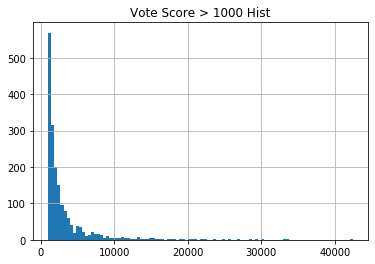

In [85]:
df[df.score>1000]['score'].hist(bins=100)
plt.title('Vote Score > 1000 Hist')

In [81]:
(df.score > 50).sum()/df.shape[0]

0.052350141903468275

Text(0.5, 1.0, 'Vote Score < 100 Hist')

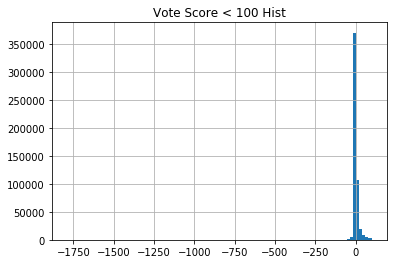

In [84]:
df[df.score < 100]['score'].hist(bins=100)
plt.title('Vote Score < 100 Hist')

In [82]:
(df.score<-1).sum()/df.shape[0]

0.05516765908789421

This is interesting to me Over 7% of the comments have negative votes which makes me think that it will be worth looking into. May be fun to see what causes something to be negative.  Maybe could do some classification to see what is the underlying things that trigger negative sentiment.

In [68]:
(df.score < -5).sum()/df.shape[0]

0.029129914073199394

In [72]:
(df.score < -0).sum()

38976

To start I am going to look at data with a score of over 50 vs data with a score of less then -1.  I am choosing less then -1 as I dont want to include things that may have been a accident down vote.  (See Notebook)

In [ ]:
df.